<span style="color: #9370DB">*Bárbara Flores*</span>

# Marijuana Legalization and Violent Crime

In recent years, many US states have decided to legalize the use of marijuana. 

When these ideas were first proposed, there were many theories about the relationship between crime and the "War on Drugs" (the term given to US efforts to arrest drug users and dealers over the past several decades). 

In this exercise, we're going to test a few of those theories using drug arrest data from the state of California. 

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in  2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale. 

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common. 

**To be clear,** this is far from the only argument for drug legalization! It is simply the argument we are well positioned to analyze today. 

(Students from Practical Data Science: This should sound familiar! Last semester we did this analysis in a very simple, crude manner; in this class we'll do it rigorously with your new found difference-in-differences skills!)

## Exercise 1

Download and import California arrest data from [https://www.github.com/nickeubank/MIDS_Data/UDS_arrest_data.csv](https://www.github.com/nickeubank/MIDS_Data/UDS_arrest_data.csv). What is a unit of observation (a single row) in this data? What entities are being tracked, and over what time period? (This data is derived from raw California arrest data from the State Attorney General's office [here](https://openjustice.doj.ca.gov/data), in the "Arrests" category.)

Note that `VIOLENT` is a count of arrests for violent offenses, and `F_DRUGOFF` is a count of felony drug arrests. `total_population` is total population. 

In [35]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import linearmodels as lm


path = "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/UDS_arrest_data.csv"
arrest_data = pd.read_csv(path)
arrest_data

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population
0,1980,Alameda County,4504,3569,1105379.0
1,1981,Alameda County,4699,3926,1122759.3
2,1982,Alameda County,4389,4436,1140139.6
3,1983,Alameda County,4500,5086,1157519.9
4,1984,Alameda County,3714,5878,1174900.2
...,...,...,...,...,...
2257,2014,Yuba County,392,329,72155.0
2258,2015,Yuba County,454,194,72155.0
2259,2016,Yuba County,491,154,72155.0
2260,2017,Yuba County,464,121,72155.0


In [36]:
assert not arrest_data.duplicated(["YEAR", "COUNTY"]).any()

In [37]:
arrest_data["YEAR"].value_counts().sort_index()

1980    58
1981    58
1982    58
1983    58
1984    58
1985    58
1986    58
1987    58
1988    58
1989    58
1990    58
1991    58
1992    58
1993    58
1994    58
1995    58
1996    58
1997    58
1998    58
1999    58
2000    58
2001    58
2002    58
2003    58
2004    58
2005    58
2006    58
2007    58
2008    58
2009    58
2010    58
2011    58
2012    58
2013    58
2014    58
2015    58
2016    58
2017    58
2018    58
Name: YEAR, dtype: int64

>- Our unit of observation is county per year.
>- The entity we are tracking is California's counties
>- The period we have is from 1980 to 2018.
>
>- For each year, we have information on 58 counties of California.

## Exercise 2

In this analysis, we will split our sample into "treated" and "control" on the basis of whether a given county had a high average drug arrest rate in the three years before California began drug legalization in 2010. Counties with high drug arrest rates, after all, will be more impacted by drug liberalization policies. 

Calculate each county's average drug arrest *rate* for the period from 2007-2009. Then calculate the median value across counties, and create an indicator called `treated` for counties whose average drug arrest rate during this period was above the median average drug arrest rate. In other words, half your counties should be in the "treated" group, and half in "control". 

Note that this indicator should be *time-invariant*—if a county is in the treated group, it should always be identified as being in the treated group. 

In [38]:
arrest_data_07_09 = arrest_data[
    (arrest_data["YEAR"] >= 2007) & (arrest_data["YEAR"] <= 2009)
].copy()

arrest_data_07_09["drug_arrest_rate"] = (
    arrest_data_07_09["F_DRUGOFF"] / arrest_data_07_09["total_population"]
)


arrest_data_07_09["avg_county_drug_arrest_rate_07_09"] = arrest_data_07_09.groupby(
    "COUNTY"
)[["drug_arrest_rate"]].transform("mean")

arrest_data_07_09 = arrest_data_07_09[["COUNTY", "avg_county_drug_arrest_rate_07_09"]]

arrest_data = arrest_data.merge(arrest_data_07_09, how="left", on="COUNTY")
arrest_data

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,avg_county_drug_arrest_rate_07_09
0,1980,Alameda County,4504,3569,1105379.0,0.003945
1,1980,Alameda County,4504,3569,1105379.0,0.003945
2,1980,Alameda County,4504,3569,1105379.0,0.003945
3,1981,Alameda County,4699,3926,1122759.3,0.003945
4,1981,Alameda County,4699,3926,1122759.3,0.003945
...,...,...,...,...,...,...
6781,2017,Yuba County,464,121,72155.0,0.003516
6782,2017,Yuba County,464,121,72155.0,0.003516
6783,2018,Yuba County,391,164,72155.0,0.003516
6784,2018,Yuba County,391,164,72155.0,0.003516


In [39]:
median = arrest_data_07_09["avg_county_drug_arrest_rate_07_09"].median()
print("median:", round(median, 5))
arrest_data["treated"] = arrest_data["avg_county_drug_arrest_rate_07_09"] >= median
arrest_data.groupby("treated")["COUNTY"].nunique()

median: 0.00302


treated
False    29
True     29
Name: COUNTY, dtype: int64

>Our median of county's average drug arrest rate for the period from 2007-2009 is 0.00302. 
>
>With this threshold, we have 29 counties in the treatment group and 29 in the control.

## Exercise 3

Our outcome in this analysis is the violent arrest rate -- if drug liberalization reduces crime overall, we would expect to see this rate fall in counties with high drug arrest rates after liberalization; if not, we would not expect to see any changes. Create a `violent_rate` variable with is violent arrests per 100,000 people. 

In [40]:
arrest_data["violent_rate"] = (
    arrest_data["VIOLENT"] / arrest_data["total_population"] * 100000
)
arrest_data

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,avg_county_drug_arrest_rate_07_09,treated,violent_rate
0,1980,Alameda County,4504,3569,1105379.0,0.003945,True,407.462056
1,1980,Alameda County,4504,3569,1105379.0,0.003945,True,407.462056
2,1980,Alameda County,4504,3569,1105379.0,0.003945,True,407.462056
3,1981,Alameda County,4699,3926,1122759.3,0.003945,True,418.522474
4,1981,Alameda County,4699,3926,1122759.3,0.003945,True,418.522474
...,...,...,...,...,...,...,...,...
6781,2017,Yuba County,464,121,72155.0,0.003516,True,643.060079
6782,2017,Yuba County,464,121,72155.0,0.003516,True,643.060079
6783,2018,Yuba County,391,164,72155.0,0.003516,True,541.888989
6784,2018,Yuba County,391,164,72155.0,0.003516,True,541.888989


## Exercise 4

Differences-in-differences get their name from the fact that the estimator, in its most basic implementation, is just the difference between:

-  difference in the average change in outcome among eventually-treated units from before to after when treatment is applied, and
-  difference in the average change in outcome among never-treated units from before to after when treatment (to the treated units). 

(Obviously treatment is never a applied to the never-treated units -- when we talk about pre / post, we refer to before and after the point in time in which treatment is applied to the treated units. So if treated units are treated in 2008, then for the never-treated units, we are also comparing outcomes before 2008 to after 2008, even though 2008 has no special significance for the never-treated units). 

In its most basic implementation, therefore, calculating a difference-in-difference estimate requires calculating just 4 numbers:

- $\bar y_{T=1,Post}$  Avg for Treatment, Post-Treatment
- $\bar y_{T=0,Post}$  Avg for Control, Post-Treatment
- $\bar y_{T=1,Pre}$   Avg for Treatment, Pre-Treatment
- $\bar y_{T=0,Pre}$   Avg for Control, Pre-Treatment

The difference-in-differences estimator $\hat \delta$  is defined as

$$
\hat{\delta}= (\bar{y}_{T=1,\,Post}-\bar{y}_{T=1,\,Pre})-(\bar{y}_{T=0,\,Post}-\bar{y}_{T=0,\,Pre})
$$



Calculate (a) the change in violent arrest rates for our treated groups from before legalization to after ($\bar y_{T=1,Post} - \bar y_{T=1, Pre}$), and (b) our difference in difference estimator $\hat\delta$ by calculating these four values. Does doing your difference-in-difference estimate tell you something different from what you'd learn if you had just done a pre-post comparison?

For the `Pre` period, consider the three years before liberalization begins in 2010 (e.g. 2007-2009). For the `Post` period, consider the three years after final legalization took place (2016-2018). We will ignore the middle period in which marijuana was decriminalized but not yet legal. 

In [41]:
arrest_data.loc[
    (arrest_data["YEAR"] >= 2007) & (arrest_data["YEAR"] <= 2009), "period"
] = "pre"
arrest_data.loc[
    (arrest_data["YEAR"] >= 2016) & (arrest_data["YEAR"] <= 2018), "period"
] = "post"

avg_violent_rate_control_pre = arrest_data[
    (arrest_data["period"] == "pre") & (arrest_data["treated"] == 0)
]["violent_rate"].mean()

avg_violent_rate_control_post = arrest_data[
    (arrest_data["period"] == "post") & (arrest_data["treated"] == 0)
]["violent_rate"].mean()

avg_violent_rate_treatment_pre = arrest_data[
    (arrest_data["period"] == "pre") & (arrest_data["treated"] == 1)
]["violent_rate"].mean()

avg_violent_rate_treatment_post = arrest_data[
    (arrest_data["period"] == "post") & (arrest_data["treated"] == 1)
]["violent_rate"].mean()

print(
    f"Average Violent Rate for Control, Pre-Treatment: {avg_violent_rate_control_pre:.0f} arrests per 100,000 people"
)
print(
    f"Average Violent Rate for Control, Post-Treatment: {avg_violent_rate_control_post:.0f} arrests per 100,000 people"
)
print(
    f"Average Violent Rate for Treatment, Pre-Treatment: {avg_violent_rate_treatment_pre:.0f} arrests per 100,000 people"
)

print(
    f"Average Violent Rate for Treatment, Post-Treatment: {avg_violent_rate_treatment_post:.0f} arrests per 100,000 people"
)

Average Violent Rate for Control, Pre-Treatment: 320 arrests per 100,000 people
Average Violent Rate for Control, Post-Treatment: 300 arrests per 100,000 people
Average Violent Rate for Treatment, Pre-Treatment: 427 arrests per 100,000 people
Average Violent Rate for Treatment, Post-Treatment: 400 arrests per 100,000 people


In [42]:
# a) Change in violent arrest rates for treated groups from before legalization to after
pre_post = avg_violent_rate_treatment_post - avg_violent_rate_treatment_pre
print(
    f"Pre-Post. Change in Violent Arrest Rates for Treated Groups from Before to After Legalization: {pre_post:.2f} arrests per 100,000 people"
)

# b) Difference-in-difference estimator 𝛿 by calculating these four values
diff_in_diff = (avg_violent_rate_treatment_post - avg_violent_rate_treatment_pre) - (
    avg_violent_rate_control_post - avg_violent_rate_control_pre
)
print(
    f"\nDifference-in-Difference Estimator: {diff_in_diff:.2f} arrests per 100,000 people"
)

Pre-Post. Change in Violent Arrest Rates for Treated Groups from Before to After Legalization: -26.80 arrests per 100,000 people

Difference-in-Difference Estimator: -7.42 arrests per 100,000 people



>The results obtained from the pre-post analysis and the Difference-in-Difference approach show discrepancies in the impact of violent crime of the 2016 policy in California, when recreational marijuana use was fully legalized.
>
>The pre-post analysis indicates a reduction of 26.8 arrests per 100,000 people, while the Diff in diff analysis shows a lower reduction of 7.42 arrests per 100,000 people.
>
>This suggests that if we were to rely solely on the pre-post analysis, we would be overestimating the policy's impact. The reason for this discrepancy lies in the fact that, during the pre and post periods regardless of the policy, there was a general trend of reducing violent crimes. Therefore, the pre-post analysis would fail to account for this underlying trend and incorrectly attribute the entire reduction in violent arrests to the policy's effect, resulting in an overestimation of its actual impact on the treated group.
>
>On the other hand, the Diff in diff approach controls for this trend by comparing the difference between the treated and control groups both before and after the policy implementation. By accounting for this general trend of reducing violent crimes, Diff in diff provides a more accurate estimation of the policy's true effect on the treated group, revealing a smaller but still significant effective impact.

## Exercise 5

Now calculate $\hat\delta$ using a regression with an indicator for post-2010, an indicator for treated, and an interaction of the two. Use only the same set of years you used above. How does your estimate compare to the estimate you calculated in Exercise 4?

What does this tell you about interpretation of interaction terms with two indicator variables?

Note: You need to cluster your standard errors by county, since we expect counties (over time) to be subject to common fluctuations. 

In [43]:
arrest_data_subset = arrest_data[arrest_data["period"].notna()].copy()
arrest_data_subset["post"] = arrest_data_subset["period"] == "post"

In [44]:
model = smf.ols("violent_rate ~ post + treated + post*treated",
                data=arrest_data_subset)
results = model.fit(
    cov_type="cluster", cov_kwds={"groups": arrest_data_subset["COUNTY"]}
)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           violent_rate   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     11.06
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           7.96e-06
Time:                        01:52:44   Log-Likelihood:                -6282.2
No. Observations:                1044   AIC:                         1.257e+04
Df Residuals:                    1040   BIC:                         1.259e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       


> Both the estimate obtained in Exercise 4 using the difference-in-differences method directly and the coefficient we obtained for the interaction between post and treated are exactly the same: -7.42 arrests per 100,000 people.
>
>This tells us that conducting a pre-post analysis is equivalent to calculating the coefficient of interaction between our treatment indicator and our post-period indicator.

## Exercise 6

In the preceding exercise, we did a simple pre-post / treated-control comparison. But one important limitation of these designs is that they do not allow us to test for *parallel trends*. 

**Plot** a difference-in-difference model using data from 2000-2009 (inclusive) and from 2016-2018 (inclusive). Note this will have four different geometric components: a time trend for treated counties pre-2010, a time trend for control counties pre-2010, a time trend for treated counties post-2016 (include 2016), and a time trend for control counties post-2016 (include 2016). 

Do you see evidence of parallel trends for these two datasets? Does that make you feel more or less confident in your diff-in-diff estimates?

In [45]:
treated_data_2000_2009 = arrest_data[
    (arrest_data["treated"] == True)
    & (arrest_data["YEAR"] >= 2000)
    & (arrest_data["YEAR"] <= 2009)
]
treated_data_2016_2018 = arrest_data[
    (arrest_data["treated"] == True)
    & (arrest_data["YEAR"] >= 2016)
    & (arrest_data["YEAR"] <= 2018)
]
control_data_2000_2009 = arrest_data[
    (arrest_data["treated"] == False)
    & (arrest_data["YEAR"] >= 2000)
    & (arrest_data["YEAR"] <= 2009)
]
control_data_2016_2018 = arrest_data[
    (arrest_data["treated"] == False)
    & (arrest_data["YEAR"] >= 2016)
    & (arrest_data["YEAR"] <= 2018)
]

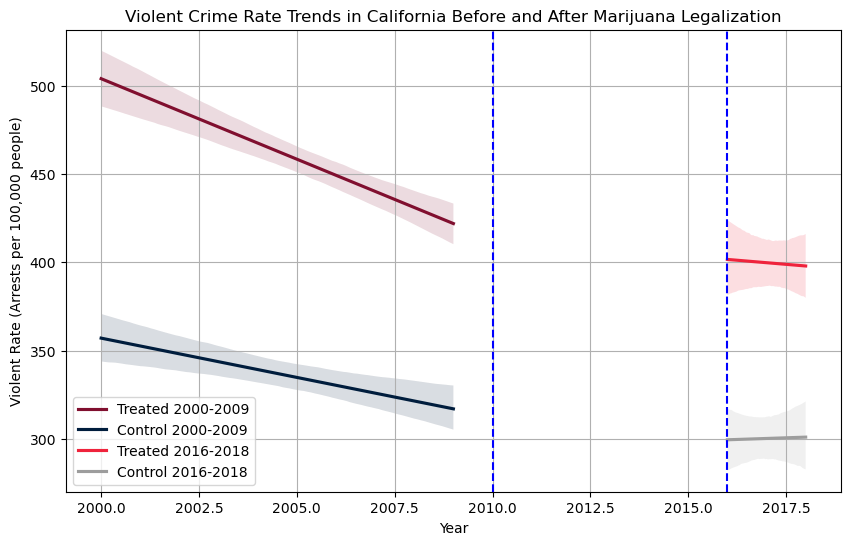

In [46]:
plt.figure(figsize=(10, 6))

sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=treated_data_2000_2009,
    scatter=False,
    label="Treated 2000-2009",
    color="#800f2f",
)
sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=control_data_2000_2009,
    scatter=False,
    label="Control 2000-2009",
    color="#001d3d",
)

sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=treated_data_2016_2018,
    scatter=False,
    label="Treated 2016-2018",
    color="#ef233c",
)
sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=control_data_2016_2018,
    scatter=False,
    label="Control 2016-2018",
    color="#9D9D9D",
)
plt.axvline(x=2010, color="blue", linestyle="--")
plt.axvline(x=2016, color="blue", linestyle="--")

plt.xlabel("Year")
plt.ylabel("Violent Rate (Arrests per 100,000 people)")
plt.title(
    "Violent Crime Rate Trends in California Before and After Marijuana Legalization"
)

plt.legend()

plt.grid(True)
plt.show()

> When graphing our data, we can observe that there is a parallel trend between the treatment and control groups prior to the implementation period of the policy in California. This increases our confidence in our estimations, as we can see that both groups were following a similar trend previously.
>
>However, something that could make us question our results is that in the years 2016 to 2018, following the implementation of the policy, the violent rate in the treatment group has a positive slope while in the control group the slope is negative. This could give us indications that while the policy initially reduced the violent rate, perhaps this effect will not be sustained in the long term. It would probably be necessary to study the information for subsequent years to confirm this.

## Exercise 7

While we can estimate the model described above precisely as a regression, it's actually much easier to estimate a more flexible model by running the regression we ran in Exercise 5 but with both `county` and `year` fixed effects. Use `PanelOLS` (or `lfe` in R) to estimate this fixed effects regression. 

With all these additional fixed effects, do you find evidence that marijuana legalization reduced violent crime?

In [47]:
arrest_data_subset.set_index(["COUNTY", "YEAR"], inplace=True)
arrest_data_subset

VIOLENT  F_DRUGOFF  total_population  \
COUNTY         YEAR                                         
Alameda County 2007     4443       6071         1490312.0   
               2007     4443       6071         1490312.0   
               2007     4443       6071         1490312.0   
               2008     4336       5893         1496965.0   
               2008     4336       5893         1496965.0   
...                      ...        ...               ...   
Yuba County    2017      464        121           72155.0   
               2017      464        121           72155.0   
               2018      391        164           72155.0   
               2018      391        164           72155.0   
               2018      391        164           72155.0   

                     avg_county_drug_arrest_rate_07_09  treated  violent_rate  \
COUNTY         YEAR                                                             
Alameda County 2007                           0.003945     True    298.125493   
               2007                           0.003945     True    298.125493   
               2007                           0.003945     True    298.125493   
               2008                           0.003945     True    289.652731   
               2008                           0.003945     True    289.652731   
...                                                ...      ...           ...   
Yuba County    2017                           0.003516     True    643.060079   
               2017                           0.003516     True    643.060079   
               2018                           0.003516     True    541.888989   
               2018                           0.003516     True    541.888989   
               2018                           0.003516     True    541.888989   

                    period   post  
COUNTY         YEAR                
Alameda County 2007    pre  False  
               2007    pre  False  
               2007    pre  False  
               2008    pre  False  
               2008    pre  False  
...                    ...    ...  
Yuba County    2017   post   True  
               2017   post   True  
               2018   post   True  
               2018   post   True  
               2018   post   True  

[1044 rows x 8 columns]

In [48]:
mod = lm.PanelOLS.from_formula(
    "violent_rate  ~ 1 +  post +  EntityEffects ",
    data=arrest_data_subset,
)
mod.fit()

Dep. Variable:,violent_rate,R-squared:,0.0483
Estimator:,PanelOLS,R-squared (Between):,-4.441e-16
No. Observations:,1044,R-squared (Within):,0.0483
Date:,"Mon, Apr 15 2024",R-squared (Overall):,0.0105
Time:,01:52:44,Log-likelihood,-5590.9
Cov. Estimator:,Unadjusted,,
,,F-statistic:,50.024
Entities:,58,P-value,0.0000
Avg Obs:,18.000,Distribution:,"F(1,985)"
Min Obs:,18.000,,
Max Obs:,18.000,F-statistic (robust):,50.024


> After incorporating additional fixed effects for county and year, the analysis suggests evidence that marijuana legalization may have contributed to a reduction in violent crime in California. Specifically, the coefficient estimate for the variable representing the period after legalization is -23.091. This negative coefficient implies that, on average, violent crime decreased by approximately 23.091 arrests per 100,000 people following marijuana legalization. 